# Gaussian Mixture Models (GMM)

A GMM is a probability density distribution composed of multiple Gaussians (components).
An observation $\mathbf{x}$ is generated by the $k$th of $K$ components according to some probability $\pi_k$.
Hence the density of $\mathbf{x}$ is given by:

$$f_\mathbf{X|\Theta}(\mathbf{x}|\Theta) = \sum_{k=1}^K \pi_k g_k(\mathbf{x}|\theta_k)$$

where $g_k(\mathbf{x}|\theta_k)$ is a Gaussian distribution with parameters $\theta_k = (\mu,\mathbf{\Sigma})_k$,
and all parameters are in $\Theta = ((\pi,\mu,\mathbf{\Sigma})_k: k\in\{1,K\})$.

## Illustration

A recipe for generating a dataset:
- Observations $\mathbf{x}\in\mathbb{R}^2$.
- Most of the time we make an observation, it is generated by one multivariate Gaussian
- The rest of the time it is generated by another multivariate Gaussian
- Define $\pi_1,\pi_2$ in proportion to frequency
- Define parameters of each multivariate Gaussian
- Sample!

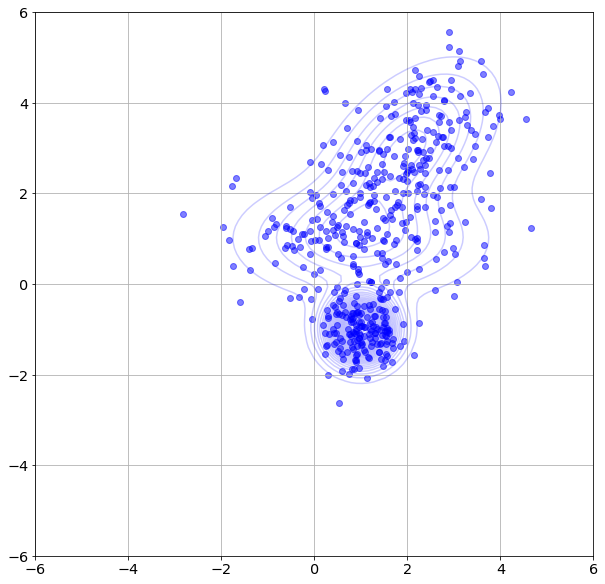

In [14]:
import numpy as np
N = 500
pi = [0.33,0.33,0.34]
K = len(pi)
param_muA1 = [2,3]; param_muA2 = [1,1]; param_muA3 = [1,-1]; 
param_CA1 = np.array([[1,0.5],[0.5,1]]); param_CA2 = np.array([[2,0],[0,0.5]])
param_CA3 = np.array([[1,0],[0,1]])/5

from sklearn import mixture
import scipy

GMMA = mixture.GaussianMixture(K)
GMMA.fit(np.random.uniform(size=[N,2])) # this is just to instantiate the object in R2
GMMA.weights_ = pi
GMMA.means_ = np.array([param_muA1, param_muA2,param_muA3])
GMMA.covariances_ = np.array([param_CA1, param_CA2,param_CA3])
ZA = GMMA.sample(N)

xx, yy = np.meshgrid(np.linspace(-6,6,100), np.linspace(-6,6,100))
points = np.stack((xx, yy), axis=-1)
pdfA1_true = scipy.stats.multivariate_normal.pdf(points, param_muA1, param_CA1)
pdfA2_true = scipy.stats.multivariate_normal.pdf(points, param_muA2, param_CA2)
pdfA3_true = scipy.stats.multivariate_normal.pdf(points, param_muA3, param_CA3)

import matplotlib.pyplot as plt
# The following makes the plot look nice
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 10),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.scatter(ZA[0][:,0],ZA[0][:,1],alpha=0.5,c='blue')
ax.contour(xx, yy, GMMA.weights_[0]*pdfA1_true+GMMA.weights_[1]*pdfA2_true+GMMA.weights_[2]*pdfA3_true, 
           levels=40, colors='blue', alpha=0.2)
plt.grid()
plt.show()

## Illustration

Now we want to fit a GMM to a given dataset:
- Select number of components $K$.
- Run expectation maximization (EM) on the dataset.
- Results are not deterministic, so run several times with random initializations.
- Possibility of failure, e.g., $K$ too large.

See [sklearn.mixture](https://scikit-learn.org/stable/modules/mixture.html)

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
Initialization converged: True
Mixture weights: [0.34740544 0.3402191  0.31237547] True: [0.33, 0.33, 0.34]


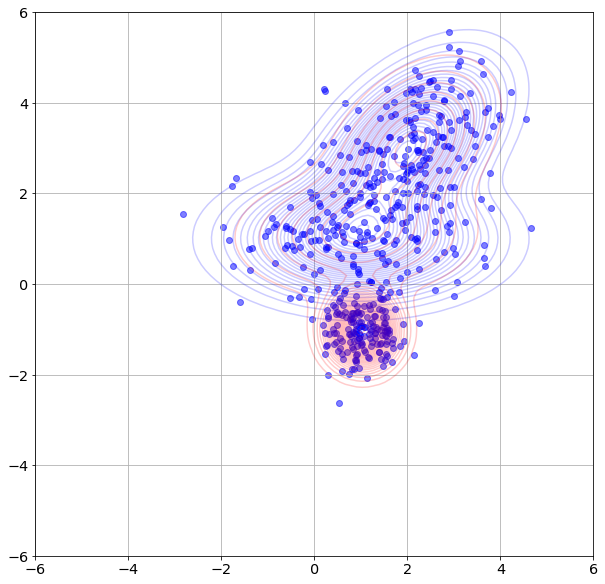

In [15]:
K = 3
GMMA_hat = mixture.GaussianMixture(K,covariance_type='full',verbose=1,
                                   n_init=5,init_params='kmeans',warm_start=True)
GMMA_hat.fit(ZA[0])
print('Mixture weights:',GMMA_hat.weights_,'True:',pi)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.scatter(ZA[0][:,0],ZA[0][:,1],alpha=0.5,c='blue')
xx, yy = np.meshgrid(np.linspace(-6,6,100), np.linspace(-6,6,100))
points = np.stack((xx, yy), axis=-1)
ax.contour(xx, yy, GMMA.weights_[0]*pdfA1_true+GMMA.weights_[1]*pdfA2_true, 
           levels=40, colors='blue', alpha=0.2)
pdf_hat = []

for kk in range(K):
    if len(GMMA_hat.covariances_.shape) == 2:
        pdf_hat.append(GMMA_hat.weights_[kk]*
                       scipy.stats.multivariate_normal.pdf(points, GMMA_hat.means_[kk], GMMA_hat.covariances_[0]))
    else:
        pdf_hat.append(GMMA_hat.weights_[kk]*
                       scipy.stats.multivariate_normal.pdf(points, GMMA_hat.means_[kk], GMMA_hat.covariances_[kk]))
sumpdf_hat = np.array(pdf_hat).sum(axis=0)
ax.contour(xx, yy, sumpdf_hat, 
           levels=40, colors='red', alpha=0.2)
plt.grid(); plt.show()


### How do we judge model fit? How do we choose $K$?

A GMM allows us to compute a density for each point in the dataset.

We can compute the negative log likelihood of the training set given $\Theta$. 

$$\begin{align}L_\mathcal{D}(\Theta)  = -\log P[\mathcal{D}|\Theta] & = -\log \prod_{n=1}^N f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)\\
& = -\sum_{n=1}^N \log f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)\end{align}$$
assuming all observations are iid.

If our model is quite far from our data, we expect this value to be large.

Thus, we can compute $L_\mathcal{D}(\Theta)$ for several $K$ and select the order based on this.

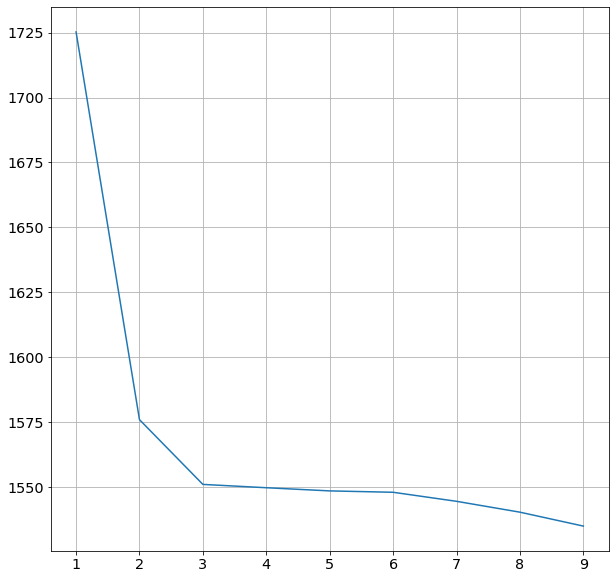

In [16]:
llvals = []
KK = range(1,10)
for kk in KK:
    GMMA_hat = mixture.GaussianMixture(kk,covariance_type='full',verbose=0,
                                   n_init=5,init_params='kmeans',warm_start=False)
    GMMA_hat.fit(ZA[0])
    llvals.append(-np.sum(GMMA_hat.score_samples(ZA[0])))

fig = plt.figure(); ax = fig.add_subplot(111)
plt.plot(KK,llvals,label='LL')
plt.grid(); plt.draw()

### How do we judge model fit? How do we choose $K$?

Another measure is the Akaike information criterion (AIC), which considers the number of model parameters $M$:

$$AIC(M) = 2M-2\log \prod_{n=1}^N f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)$$

Yet another measure is the Bayes information criterion (BIC), which also considers the number of observations $N$:

$$BIC(M) = M\log(N) - 2\log \prod_{n=1}^N f_\mathbf{X|\theta_i}(\mathbf{x}_n|\theta_i)$$


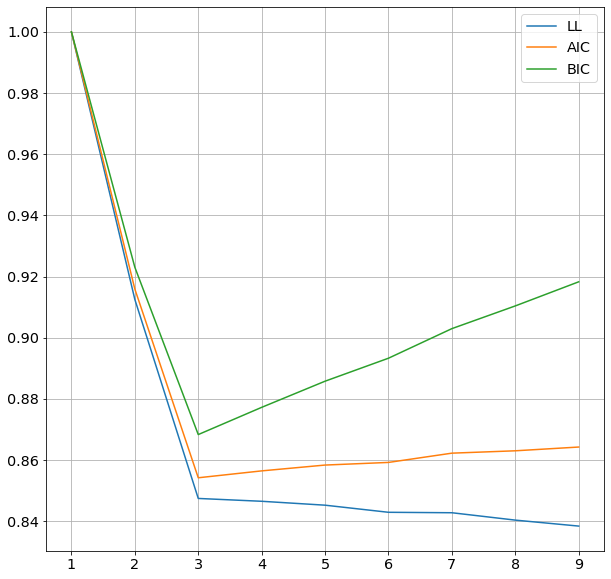

In [7]:
llvals = []
aic = []
bic = []
KK = range(1,10)
for kk in KK:
    GMMA_hat = mixture.GaussianMixture(kk,covariance_type='full',verbose=0,
                                   n_init=5,init_params='kmeans',warm_start=False)
    GMMA_hat.fit(ZA[0])
    llvals.append(-np.sum(GMMA_hat.score_samples(ZA[0])))
    aic.append(GMMA_hat.aic(ZA[0]))
    bic.append(GMMA_hat.bic(ZA[0]))
    

fig = plt.figure(); ax = fig.add_subplot(111)
plt.plot(KK,llvals/np.max(llvals),label='LL')
plt.plot(KK,aic/np.max(aic),label='AIC')
plt.plot(KK,bic/np.max(bic),label='BIC')
plt.legend()
plt.grid(); plt.draw()